# MLPRegressor

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from statsmodels.tools.eval_measures import stde

import kerastuner as kt
import tensorflow as tf


2022-11-20 21:03:55.657960: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-20 21:03:55.788600: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-20 21:03:56.243796: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nkspartan/miniconda3/envs/tf-gpu/lib/
2022-11-20 21:03:56.243860: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfe

In [2]:
from tensorflow.python.client import device_lib

print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

2022-11-20 21:03:56.739884: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Default GPU Device: /device:GPU:0


2022-11-20 21:03:56.757368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 21:03:56.762486: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 21:03:56.762693: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 21:03:57.191126: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 21:03:57.191336: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

## Read the etl info results

In [3]:
df_info = pd.read_csv('../dataset_clean/options_csv_v1_etl.csv')
df_info

,remove_time_features,generic_features,remove_atypical_values,feature_combination,remove_feature_selection,remove_invalid_correlated_features
0,False,False,False,False,False,False


## Read the dataset

In [4]:
df = pd.read_csv('../dataset/V2_PlatteRiverWeir_features_merged_all.csv')
df

,Unnamed: 0.1,Unnamed: 0,SensorTime,CaptureTime,Filename,Agency,SiteNumber,TimeZone,Stage,Discharge,...,WwRawLineMin,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMin,WwCurveLineMax,WwCurveLineMean,WwCurveLineSigma,RiverArea,RiverWidth
0,0,0,2012-06-09 13:15:00,2012-06-09T13:09:07,statelineweir_20120609_farrell_001.jpg,USGS,6674500,MDT,2.99,916.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,49975.0,207.508733
1,1,1,2012-06-09 13:15:00,2012-06-09T13:10:29,statelineweir_20120609_farrell_002.jpg,USGS,6674500,MDT,2.99,916.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,50184.0,208.663145
2,2,2,2012-06-09 13:45:00,2012-06-09T13:44:01,statelineweir_20120609_farrell_003.jpg,USGS,6674500,MDT,2.96,873.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,50543.0,209.445067
3,3,3,2012-06-09 14:45:00,2012-06-09T14:44:30,statelineweir_20120609_farrell_004.jpg,USGS,6674500,MDT,2.94,846.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,50856.0,211.265690
4,4,4,2012-06-09 15:45:00,2012-06-09T15:44:59,statelineweir_20120609_farrell_005.jpg,USGS,6674500,MDT,2.94,846.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,51004.0,211.250274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42054,42054,42054,2019-10-11 09:00:00,2019-10-11T08:59:53,statelineweir_20191011_farrell_409.jpg,USGS,6674500,MDT,2.54,434.0,...,9284.0,77521.0,38385.370066,15952.029728,0.0,70085.0,37550.894823,16444.401209,45842.0,194.934605
42055,42055,42055,2019-10-11 10:00:00,2019-10-11T09:59:52,statelineweir_20191011_farrell_410.jpg,USGS,6674500,MDT,2.54,434.0,...,10092.0,74614.0,40162.989292,15467.708856,0.0,70061.0,39397.339095,16009.008049,42300.0,194.762264
42056,42056,42056,2019-10-11 11:00:00,2019-10-11T10:59:52,statelineweir_20191011_farrell_411.jpg,USGS,6674500,MDT,2.54,434.0,...,7067.0,83260.0,42095.946590,16770.357949,0.0,76335.0,41350.006568,17489.374617,41080.0,196.480105
42057,42057,42057,2019-10-11 12:00:00,2019-10-11T11:59:53,statelineweir_20191011_farrell_412.jpg,USGS,6674500,MDT,2.54,434.0,...,6283.0,83045.0,45345.490954,17498.432849,0.0,78882.0,44553.920296,18268.294896,40976.0,193.595245


In [5]:
df['SensorTime'] = pd.to_datetime(df['SensorTime'])
df['Year'] = df['SensorTime'].dt.year
df['Month'] = df['SensorTime'].dt.month

In [6]:
df.dtypes

Unnamed: 0.1                 int64
Unnamed: 0                   int64
SensorTime          datetime64[ns]
CaptureTime                 object
Filename                    object
                         ...      
WwCurveLineSigma           float64
RiverArea                  float64
RiverWidth                 float64
Year                         int64
Month                        int64
Length: 65, dtype: object

In [7]:
df = df[df.Stage > 0]
df = df[df.Discharge > 0]

In [8]:

df.isna().sum()

Unnamed: 0.1        0
Unnamed: 0          0
SensorTime          0
CaptureTime         0
Filename            0
                   ..
WwCurveLineSigma    0
RiverArea           0
RiverWidth          0
Year                0
Month               0
Length: 65, dtype: int64

## Divide dataset to X and Y

In [9]:
np.random.seed(0)

df_train = df[(df.Year >= 2012) & (df.Year <= 2016)]
df_train = df_train.iloc[np.random.permutation(len(df_train))]

df_val = df[(df.Year >= 2017) & (df.Year <= 2017)]
df_val = df_val.iloc[np.random.permutation(len(df_val))]

df_test = df[(df.Year >= 2018) & (df.Year <= 2019)]

In [10]:
df_train = df_train.drop(columns=["Year", "SensorTime", "CaptureTime"])
df_val = df_val.drop(columns=["Year", "SensorTime", "CaptureTime"])
df_test = df_test.drop(columns=["Year", "SensorTime", "CaptureTime"])

In [37]:
np.random.seed(0)

y_train = df_train[["Stage"]]
X_train = df_train[["RiverWidth", "Month"]]

y_val = df_train[["Stage"]]
X_val = df_train[["RiverWidth", "Month"]]

y_test = df_test[["Stage"]].values
X_test = df_test[["RiverWidth", "Month"]].values

'temp = list(zip(X_test.values, y_test.values))\nnp.random.shuffle(temp)\nX_test, y_test = zip(*temp)\nX_test, y_test = np.array(X_test), np.array(y_test)'

In [12]:
print(X_train.shape)
print(y_train.shape)

(20304, 2)
(20304, 1)


In [13]:
input_shape = X_train.shape[1]
output_shape = y_train.shape[1]

print(input_shape, output_shape)

2 1


## Train model

In [14]:
def model_builder(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.Input(shape=input_shape))
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value = 16, max_value = 128, step = 16)
  model.add(tf.keras.layers.Dense(units = hp_units, activation = 'tanh'))
  hp_units_2 = hp.Int('units_2', min_value = 32, max_value = 256, step = 32)
  model.add(tf.keras.layers.Dense(units = hp_units_2, activation = 'tanh'))
  hp_units_3 = hp.Int('units_3', min_value = 32, max_value = 256, step = 32)
  model.add(tf.keras.layers.Dense(units = hp_units_3, activation = 'tanh'))
  hp_units_4 = hp.Int('units_4', min_value = 64, max_value = 256, step = 64)
  model.add(tf.keras.layers.Dense(units = hp_units_4, activation = 'tanh'))
  hp_units_5 = hp.Int('units_5', min_value = 128, max_value = 512, step = 128)
  model.add(tf.keras.layers.Dense(units = hp_units_5, activation = 'tanh'))
  hp_units_6 = hp.Int('units_6', min_value = 64, max_value = 256, step = 64)
  model.add(tf.keras.layers.Dense(units = hp_units_6, activation = 'tanh'))
  hp_units_7 = hp.Int('units_7', min_value = 32, max_value = 256, step = 32)
  model.add(tf.keras.layers.Dense(units = hp_units_7, activation = 'tanh'))
  hp_units_8 = hp.Int('units_8', min_value = 16, max_value = 128, step = 16)
  model.add(tf.keras.layers.Dense(units = hp_units_8, activation = 'tanh'))

  model.add(tf.keras.layers.Dense(output_shape, activation = 'linear'))

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-4, 1e-5]) 
  
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = hp_learning_rate), loss = 'mse', metrics = ['mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae', 'mape'])
  
  return model

In [15]:
tuner = kt.RandomSearch(model_builder,
                        objective = 'val_loss', 
                        max_trials = 20,
                        #directory = 'random_search_starter',
                        project_name = 'MLPtf') 

2022-11-20 21:03:58.137878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 21:03:58.138116: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 21:03:58.138271: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 21:03:58.138606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 21:03:58.138768: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [16]:
tuner.search(X_train, y_train, epochs = 100, validation_data = (X_val, y_val))

Trial 20 Complete [00h 03m 39s]
val_loss: 0.226812481880188

Best val_loss So Far: 0.22110223770141602
Total elapsed time: 01h 12m 13s
INFO:tensorflow:Oracle triggered exit


In [17]:
best_model = tuner.get_best_models(1)[0]

In [18]:

best_hyperparameters = tuner.get_best_hyperparameters(1)[0] 

## Test model

In [19]:
best_model.evaluate(X_test, y_test)


398/398 [==============================] - 1s 1ms/step - loss: 0.1839 - mse: 0.1839 - rmse: 0.4289 - mae: 0.2608 - mape: 8.9770


[0.18393336236476898,
 0.18393336236476898,
 0.42887452244758606,
 0.26076987385749817,
 8.976960182189941]

In [29]:
y_pred = best_model.predict(X_test)

398/398 [==============================] - 0s 944us/step


In [38]:
print("R^2: ", r2_score(y_test, y_pred))
print("mse: ", mean_squared_error(y_test, y_pred))
print("rmse: ", mean_squared_error(y_test, y_pred, squared=False))
print("mae: ", mean_absolute_error(y_test, y_pred))
print("mape: ", mean_absolute_percentage_error(y_test, y_pred))
print("Error estandar: ", stde(y_test.squeeze(),
      y_pred.squeeze(), ddof=2))


R^2:  0.5290267536539754
mse:  0.18393340058449242
rmse:  0.4288745744206486
mae:  0.2607700066132979
mape:  0.08976960937747167
Error estandar:  0.4260795468236275


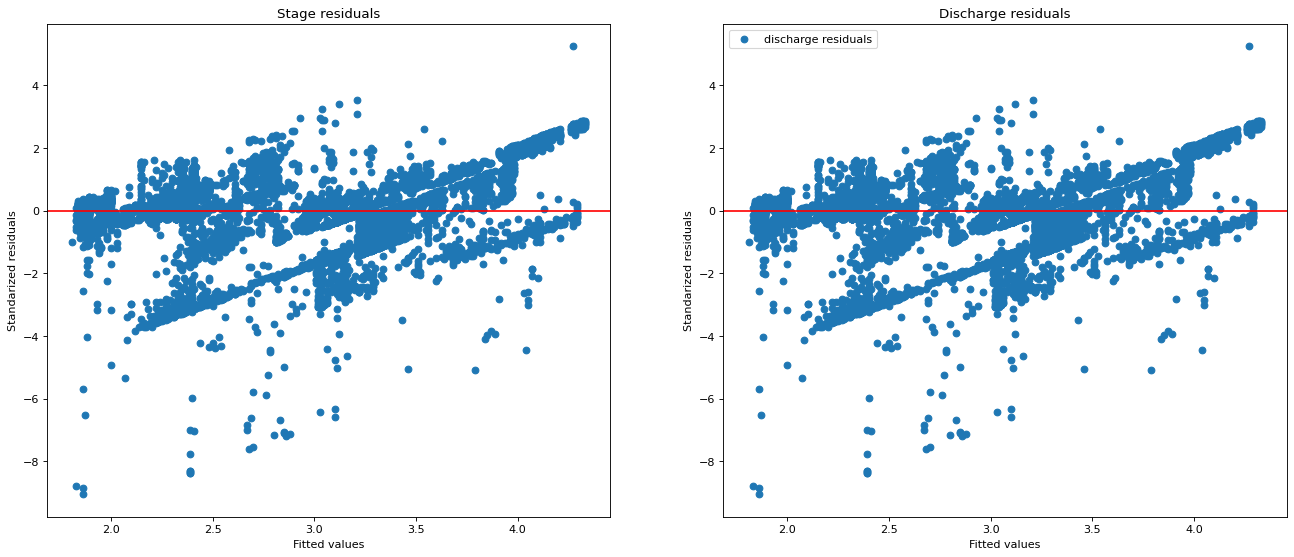

In [39]:
residuals = y_test - y_pred
residuals_std = residuals/residuals.std()

y_real_stage = np.array([i[0] for i in y_test])
residual_stage = np.array([i[0] for i in residuals])

y_real_discharge = np.array([i[-1] for i in y_test])
residual_discharge = np.array([i[-1] for i in residuals])


figure, ax = plt.subplots(ncols=2, figsize=(20, 8), dpi=80)

ax[0].scatter(y_real_stage, residual_stage / residual_stage.std(), label="stage residuals")
ax[1].scatter(y_real_discharge, residual_discharge / residual_discharge.std(), label="discharge residuals")
ax[0].axhline(y=0.0, color='r', linestyle='-')
ax[1].axhline(y=0.0, color='r', linestyle='-')

ax[0].set_title("Stage residuals")
ax[1].set_title("Discharge residuals")

ax[1].set_xlabel("Fitted values")
ax[0].set_xlabel("Fitted values")
ax[1].set_ylabel("Standarized residuals")
ax[0].set_ylabel("Standarized residuals")

plt.legend()
plt.show()

In [40]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import normal_ad

#figure = sm.qqplot(residual_stage / residual_stage.std(), line ='45', label='stage')
plt.show()

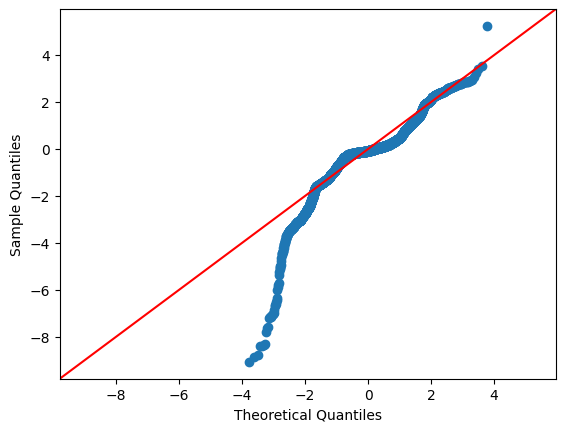

In [41]:
figure = sm.qqplot(residual_discharge / residual_discharge.std(), line='45', label='discharge')
plt.show()

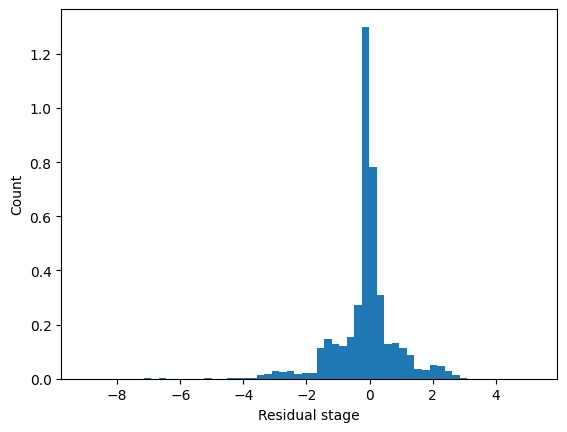

In [42]:
plt.hist(residual_stage / residual_stage.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual stage');
plt.show()

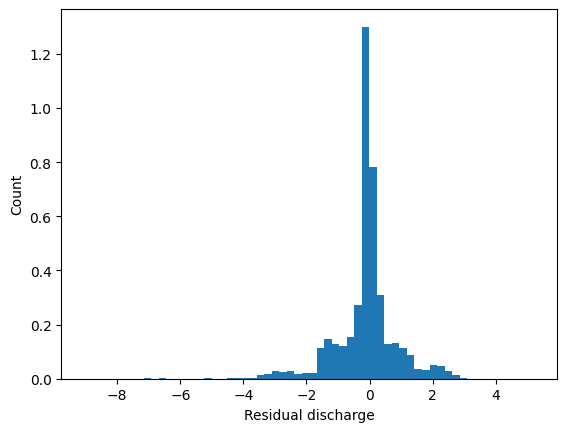

In [43]:
plt.hist(residual_discharge / residual_discharge.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual discharge');
plt.show()

In [44]:
stat, pval = normal_ad(residual_discharge / residual_discharge.std())
print("p-value:", pval)

if pval < 0.05:
    print("Hay evidencia de que los residuos no provienen de una distribución normal.")
else:
    print("No hay evidencia para rechazar la hipótesis de que los residuos vienen de una distribución normal.")


p-value: 0.0
Hay evidencia de que los residuos no provienen de una distribución normal.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


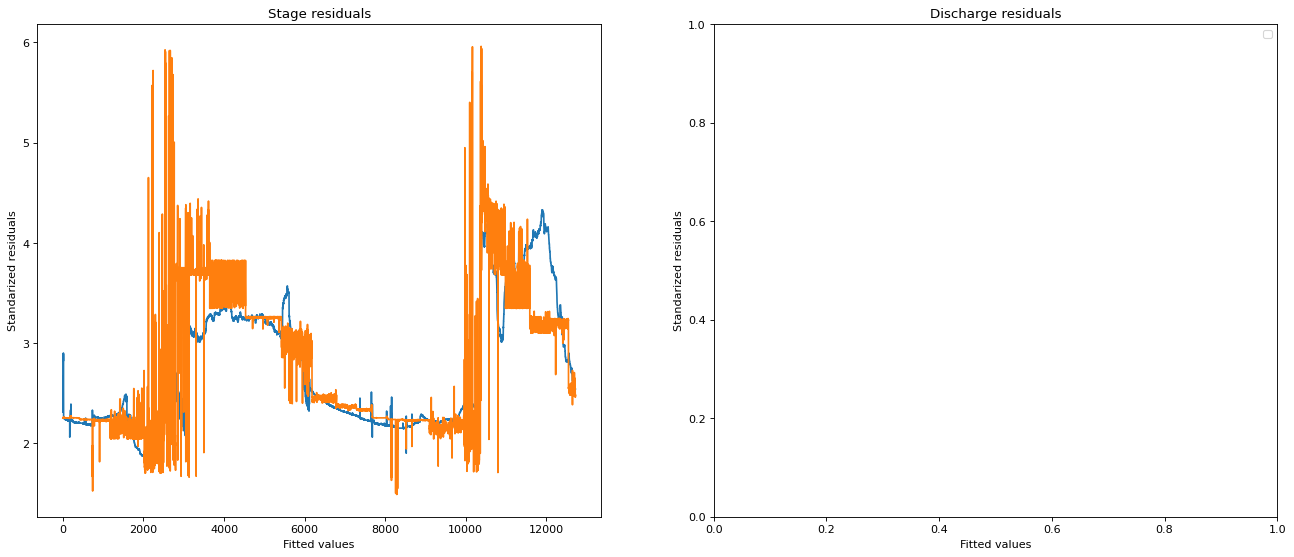

In [49]:
figure, ax = plt.subplots(ncols=2, figsize=(20, 8), dpi=80)

ax[0].plot(np.arange(len(y_test)), y_test, label="Stage real")
ax[0].plot(np.arange(len(y_test)), y_pred, label="Stage pred")

ax[0].set_title("Stage residuals")
ax[1].set_title("Discharge residuals")

ax[1].set_xlabel("Fitted values")
ax[0].set_xlabel("Fitted values")
ax[1].set_ylabel("Standarized residuals")
ax[0].set_ylabel("Standarized residuals")

plt.legend()
plt.show()